In [1]:
## data
import pandas as pd
import numpy as np
import datetime as dt
from dateutil.relativedelta import relativedelta
from unicodedata import normalize

## vis
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
# contagem de aging
from collections import Counter

from IPython.display import display, HTML

## modelo
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve
from sklearn.metrics import average_precision_score, mean_absolute_error, roc_curve, auc, roc_auc_score
from scikitplot.metrics import plot_roc
from sklearn.model_selection import cross_val_score

# check xgboost version
from xgboost import XGBClassifier, XGBRegressor

import dill as pickle

## alertas
import warnings
warnings.filterwarnings("ignore")

In [2]:
# %pip install xgboost==1.5.0

***
### Funções

In [3]:
def aucur(y_test, preds):
    # calculate AUC
    aucur = roc_auc_score(y_test, preds)
    print('AUC: %.3f' % aucur)

    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(y_test, preds)

    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.')
    # show the plot
    plt.show()

In [4]:
def just_check_nan(df):
    # Check NaN Pandas and Numpy
    missing_val_count_by_column = (df.isna().sum())

    columns_with_nan = missing_val_count_by_column[missing_val_count_by_column > 0]
    print('Dados com NaN:')
    print(columns_with_nan)
    print('')
    print('columns_with_nan.shape', columns_with_nan.shape)
    print('')

In [5]:
def plot_feature_freq(df, feature):
    labels, counts = np.unique(df[feature].dropna(), return_counts=True)
    total = counts[0] + counts[1]
    plt.figure(figsize=(10, 7))
    ax = sns.barplot(x=labels, y=(counts/total)*100, data = df)
    ax2 = sns.barplot(x=labels, y=counts, data = df)

    for p in ax.patches:
        ax.annotate('{:.2f}%'.format(p.get_height()), (p.get_x() + 0.3, p.get_height()+0.6), rotation = 0)

#     ax.set(xlabel='Trocou', ylabel='Porcentagem')
    ax.xaxis.label.set_size(20)
    ax.yaxis.label.set_size(20)
    plt.show()

In [6]:
def plot_feature_freq_mes(df, feature):
    labels, counts = np.unique(df[feature].dropna(), return_counts=True)
    total = counts[0] + counts[1] + counts[2] + counts[3] + counts[4] + counts[5] + counts[6]
    plt.figure(figsize=(20, 7))
    ax = sns.barplot(x=labels, y=(counts/total)*100, data = df)
    ax2 = sns.barplot(x=labels, y=counts, data = df)

    for p in ax.patches:
        ax.annotate('{:.2f}%'.format(p.get_height()), (p.get_x() + 0.3, p.get_height()+0.6), rotation = 45)

#     ax.set(xlabel='Trocou', ylabel='Porcentagem')
    ax.xaxis.label.set_size(20)
    ax.yaxis.label.set_size(20)
    plt.show()

***
## Coleta de dados

In [7]:
FILE = "/kaggle/input/bigdata/pca_tem_clientes_iphone_prod.csv"

In [8]:
client_chunks = []
dados_teste = pd.read_csv(FILE, sep = ";", 
                          header = 0, 
                          index_col = False, 
                          names = None, 
                          low_memory = False, 
                          chunksize = 10**5) 

In [9]:
for chunk in dados_teste:

    new_clients = pd.DataFrame(chunk)

    # filter data chunk with frac percentage
#     new_clients = new_clients.sample(frac = 0.5)
    new_clients = new_clients.drop_duplicates()

    # saves to list
    client_chunks.append(new_clients)

dados = pd.concat(client_chunks).reset_index(drop = True)

In [10]:
# FILE = "/kaggle/input/datasetsnew/batdtfim500kage.csv"
# dados = pd.read_csv(FILE, sep = ';', encoding = 'ISO-8859-1', engine ='python')

dados = dados.rename(columns={'pca_tem_clientes_iphone_prod.msisdn': 'msisdn'})\
             .rename(columns={'pca_tem_clientes_iphone_prod.imsi': 'imsi'})\
             .rename(columns={'pca_tem_clientes_iphone_prod.tac': 'tac'})\
             .rename(columns={'pca_tem_clientes_iphone_prod.dt_inicio': 'dt_inicio'})\
             .rename(columns={'pca_tem_clientes_iphone_prod.dt_fim': 'dt_fim'})\
             .rename(columns={'pca_tem_clientes_iphone_prod.aging_aparelho': 'aging_aparelho'})\
             .rename(columns={'pca_tem_clientes_iphone_prod.aging_year': 'cat_aparelho'})\
             .rename(columns={'pca_tem_clientes_iphone_prod.trocou_aparelho': 'trocou_aparelho'})\
             .rename(columns={'pca_tem_clientes_iphone_prod.fabricante': 'fabricante'})\
             .rename(columns={'pca_tem_clientes_iphone_prod.modelo': 'modelo'})\
             .rename(columns={'pca_tem_clientes_iphone_prod.imei': 'imei'})\
             .rename(columns={'pca_tem_clientes_iphone_prod.ranking': 'ranking'})\
             .rename(columns={'pca_tem_clientes_iphone_prod.cpfidentifier': 'cpfidentifier'})\
             .rename(columns={'pca_tem_clientes_iphone_prod.subscriberkey': 'subscriberkey'})\
             .rename(columns={'pca_tem_clientes_iphone_prod.customerkey': 'customerkey'})\
             .rename(columns={'pca_tem_clientes_iphone_prod.customersubtypedesc': 'customersubtypedesc'})\
             .rename(columns={'pca_tem_clientes_iphone_prod.subscriberstatuskey': 'subscriberstatuskey'})\
             .rename(columns={'pca_tem_clientes_iphone_prod.offertechnology': 'offertechnology'})\
             .rename(columns={'pca_tem_clientes_iphone_prod.citydesc': 'citydesc'})\
             .rename(columns={'pca_tem_clientes_iphone_prod.statedesc': 'statedesc'})\
             .rename(columns={'pca_tem_clientes_iphone_prod.subscribermainofferdesc': 'subscribermainofferdesc'})\
             .rename(columns={'pca_tem_clientes_iphone_prod.assignedchargeamount': 'assignedchargeamount'})\
             .rename(columns={'pca_tem_clientes_iphone_prod.fl_3g': 'fl_3g'})\
             .rename(columns={'pca_tem_clientes_iphone_prod.fl_4g': 'fl_4g'})\
             .rename(columns={'pca_tem_clientes_iphone_prod.fl_5g': 'fl_5g'})\
             .rename(columns={'pca_tem_clientes_iphone_prod.dt_ano_stts': 'dt_ano_stts'})\
             .rename(columns={'pca_tem_clientes_iphone_prod.age': 'idade'})\
             .rename(columns={'pca_tem_clientes_iphone_prod.avg_msisdn': 'avg_msisdn'})\
             .rename(columns={'pca_tem_clientes_iphone_prod.avg_cpf': 'avg_cpf'})\
             .rename(columns={'pca_tem_clientes_iphone_prod.peso_aparelho': 'peso_aparelho'})\
             .rename(columns={'pca_tem_clientes_iphone_prod.update_software': 'update_software'})\

dados

,msisdn,imsi,tac,dt_inicio,dt_fim,aging_aparelho,cat_aparelho,trocou_aparelho,fabricante,modelo,...,subscribermainofferdesc,assignedchargeamount,fl_3g,fl_4g,dt_ano_stts,idade,avg_msisdn,avg_cpf,peso_aparelho,update_software
0,5551999820515,724065202978919,35682055,2021-08-20,NaN,16,1,0,APPLE,IPHONE 12 PRO MAX (A2411),...,LINHA ADICIONAL VIVO FAMILIA 150GB,0.00,0,0,2021,90.0,0.0,0.0,2411,1
1,5551999992102,724065303215186,35391510,2019-10-19,NaN,38,3,0,APPLE,IPHONE 11 PRO MAX (A2218),...,TITULAR VIVO FAMILIA 150GB,323.56,0,1,2019,90.0,0.0,0.0,2218,1
2,5551999824802,724065202953487,35729809,2019-10-22,NaN,38,3,0,APPLE,IPHONE XS MAX (A2101),...,LINHA ADICIONAL VIVO FAMILIA 150GB,0.00,0,1,2018,90.0,0.0,0.0,2101,1
3,5551995954042,724065202953488,35003844,2021-12-17,NaN,12,1,0,APPLE,IPHONE 13 (A2633),...,TITULAR PÓS MIG 20GB,102.28,0,0,2021,90.0,0.0,0.0,2633,1
4,5566999794019,724066612780171,35298611,2020-10-23,NaN,26,2,0,APPLE,IPHONE 11 (A2221),...,LINHA ADICIONAL VIVO FAMILIA 200GB,0.00,0,1,2020,48.0,0.0,0.0,2221,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3056751,5527997767218,724113090182121,35533608,2019-06-14,NaN,42,3,0,APPLE,IPHONE 7 (A1779),...,VIVO CONTROLE 6GB III,45.99,0,1,2016,54.0,0.0,0.0,1779,0
3056752,5527996100063,724112703043033,35491409,2020-07-16,2022-08-04,24,2,1,APPLE,IPHONE 7 (A1660),...,VIVO CONTROLE 6GB III,45.99,0,1,2018,56.0,24.0,24.0,1660,0
3056753,5551997094150,724065190358565,35728409,2019-01-10,NaN,48,4,0,APPLE,IPHONE XS MAX (A2101),...,VIVO CONTROLE 11GB - ANUAL,67.03,0,1,2018,41.0,0.0,0.0,2101,1
3056754,5551981916776,724065006634070,35391410,2020-04-28,NaN,32,2,0,APPLE,IPHONE 11 PRO MAX (A2218),...,TITULAR VIVO_POS 30GB,126.70,0,1,2019,41.0,0.0,0.0,2218,1


In [11]:
dados.columns

Index(['msisdn', 'imsi', 'tac', 'dt_inicio', 'dt_fim', 'aging_aparelho',
       'cat_aparelho', 'trocou_aparelho', 'fabricante', 'modelo', 'imei',
       'ranking', 'cpfidentifier', 'subscriberkey', 'customerkey',
       'customersubtypedesc', 'subscriberstatuskey', 'offertechnology',
       'citydesc', 'statedesc', 'subscribermainofferdesc',
       'assignedchargeamount', 'fl_3g', 'fl_4g', 'dt_ano_stts', 'idade',
       'avg_msisdn', 'avg_cpf', 'peso_aparelho', 'update_software'],
      dtype='object')

### Limpeza dos dados

In [12]:
dados = dados[dados['peso_aparelho'] != 'IPHONE4']
dados = dados[dados['peso_aparelho'] != 'IPHONE3G']
dados = dados[dados['peso_aparelho'] != 'IPHONE']
dados = dados[dados['peso_aparelho'] != 'IPHONE3GS']
dados = dados[dados['peso_aparelho'] != 'DIGIPHONE K6700I']
dados = dados[dados['peso_aparelho'] != 'GENIPHONE 9 MINI']
dados = dados[dados['offertechnology'] != 'VOIP']

In [13]:
dados = dados[dados['aging_aparelho'] >= 12]

In [14]:
dados = dados[dados['aging_aparelho'] <= 48]

In [15]:
just_check_nan(dados)

Dados com NaN:
dt_fim           2641813
cpfidentifier          1
idade                  2
dtype: int64

columns_with_nan.shape (3,)



In [16]:
dados_droped = dados.dropna(subset=['imsi',
                                    'statedesc', 
                                    'subscribermainofferdesc', 
                                    'assignedchargeamount', 'fl_3g', 'fl_4g', 'dt_ano_stts', 'idade', 'customersubtypedesc'])\
                    .reset_index(drop=True)
# dados_droped

In [17]:
just_check_nan(dados_droped)

Dados com NaN:
dt_fim    2641811
dtype: int64

columns_with_nan.shape (1,)



### Mudando tipagem

In [18]:
# dados_droped = dados_droped.tail(dados_droped.shape[0] -4000000).reset_index(drop=True)
dados_droped['dt_ano_stts'] = dados_droped['dt_ano_stts'].astype(np.int64).reset_index(drop=True)
dados_droped['idade'] = np.asarray(dados_droped['idade'], dtype = 'int16')
dados_droped['fl_3g'] = np.asarray(dados_droped['fl_3g'], dtype = 'int8')
dados_droped['fl_4g'] = np.asarray(dados_droped['fl_4g'], dtype = 'int8')
# dados_droped['fl_5g'] = np.asarray(dados_droped['fl_5g'], dtype = 'int8')
dados_droped

,msisdn,imsi,tac,dt_inicio,dt_fim,aging_aparelho,cat_aparelho,trocou_aparelho,fabricante,modelo,...,subscribermainofferdesc,assignedchargeamount,fl_3g,fl_4g,dt_ano_stts,idade,avg_msisdn,avg_cpf,peso_aparelho,update_software
0,5551999820515,724065202978919,35682055,2021-08-20,NaN,16,1,0,APPLE,IPHONE 12 PRO MAX (A2411),...,LINHA ADICIONAL VIVO FAMILIA 150GB,0.00,0,0,2021,90,0.0,0.0,2411,1
1,5551999992102,724065303215186,35391510,2019-10-19,NaN,38,3,0,APPLE,IPHONE 11 PRO MAX (A2218),...,TITULAR VIVO FAMILIA 150GB,323.56,0,1,2019,90,0.0,0.0,2218,1
2,5551999824802,724065202953487,35729809,2019-10-22,NaN,38,3,0,APPLE,IPHONE XS MAX (A2101),...,LINHA ADICIONAL VIVO FAMILIA 150GB,0.00,0,1,2018,90,0.0,0.0,2101,1
3,5551995954042,724065202953488,35003844,2021-12-17,NaN,12,1,0,APPLE,IPHONE 13 (A2633),...,TITULAR PÓS MIG 20GB,102.28,0,0,2021,90,0.0,0.0,2633,1
4,5566999794019,724066612780171,35298611,2020-10-23,NaN,26,2,0,APPLE,IPHONE 11 (A2221),...,LINHA ADICIONAL VIVO FAMILIA 200GB,0.00,0,1,2020,48,0.0,0.0,2221,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3056115,5527997767218,724113090182121,35533608,2019-06-14,NaN,42,3,0,APPLE,IPHONE 7 (A1779),...,VIVO CONTROLE 6GB III,45.99,0,1,2016,54,0.0,0.0,1779,0
3056116,5527996100063,724112703043033,35491409,2020-07-16,2022-08-04,24,2,1,APPLE,IPHONE 7 (A1660),...,VIVO CONTROLE 6GB III,45.99,0,1,2018,56,24.0,24.0,1660,0
3056117,5551997094150,724065190358565,35728409,2019-01-10,NaN,48,4,0,APPLE,IPHONE XS MAX (A2101),...,VIVO CONTROLE 11GB - ANUAL,67.03,0,1,2018,41,0.0,0.0,2101,1
3056118,5551981916776,724065006634070,35391410,2020-04-28,NaN,32,2,0,APPLE,IPHONE 11 PRO MAX (A2218),...,TITULAR VIVO_POS 30GB,126.70,0,1,2019,41,0.0,0.0,2218,1


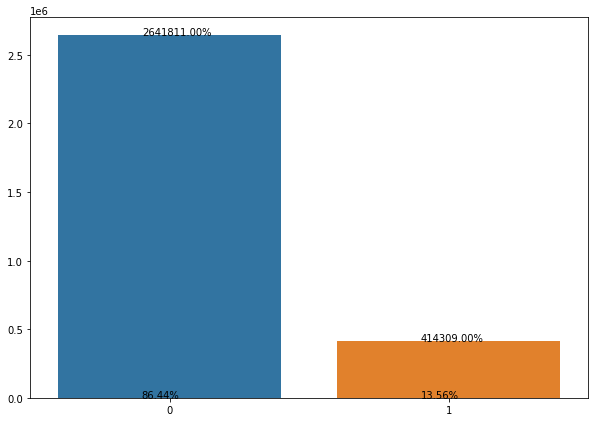

In [19]:
# plot_feature_freq(df, feature, qt_cat)
plot_feature_freq(dados_droped, 'trocou_aparelho')

In [20]:
dados_droped['dt_ano_stts'].unique()

array([2021, 2019, 2018, 2020, 2016, 2015, 2017, 2014, 2013, 2012, 2011,
       2009, 2010])

In [21]:
dados_droped['trocou_aparelho'].unique()

array([0, 1])

***
### Load Model

In [22]:
# Open saved model, and directly make the prediction with new data
filename = '/kaggle/input/models/model_trocou_aparelho_apple.pk'
with open(filename ,'rb') as f:
    pipeline_ta = pickle.load(f)

In [23]:
X_ta = dados_droped.drop('trocou_aparelho', axis=1)

y_ta = dados_droped['trocou_aparelho']

In [24]:
preds_ta = pipeline_ta.predict(X_ta)

In [25]:
c_val_ta = Counter(y_ta)
c_val_ta

Counter({0: 2641811, 1: 414309})

In [26]:
c_preds_ta = Counter(preds_ta)
c_preds_ta

Counter({0: 2641814, 1: 414306})

***
## Métricas

AUC: 1.000


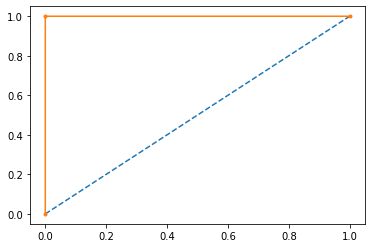

In [27]:
aucur(y_ta, preds_ta)

In [28]:
print(classification_report(y_ta, preds_ta))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   2641811
           1       1.00      1.00      1.00    414309

    accuracy                           1.00   3056120
   macro avg       1.00      1.00      1.00   3056120
weighted avg       1.00      1.00      1.00   3056120



In [29]:
cm_df_ta = pd.DataFrame(confusion_matrix(y_ta, preds_ta),
                        index = sorted(Counter(y_ta)),
                        columns = sorted(Counter(preds_ta)))
cm_df_ta

,0,1
0,2641811,0
1,3,414306


Confusion matrix, without normalization
[[2641811       0]
 [      3  414306]]
Normalized confusion matrix
[[1.00000000e+00 0.00000000e+00]
 [7.24097232e-06 9.99992759e-01]]


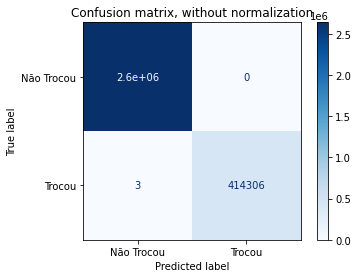

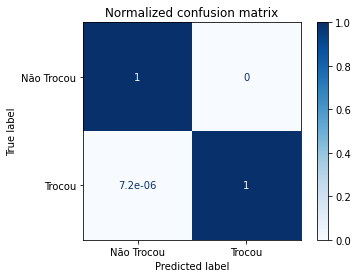

<Figure size 1296x1296 with 0 Axes>

In [30]:
# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        pipeline_ta,
        X_ta,
        y_ta,
        display_labels=['Não Trocou', 'Trocou'],
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)
    
plt.figure(figsize=(18, 18))
plt.show()

***
***
***
## Captação dos clientes que foram previstos como Propensos a Fazer uma Compra

Base Original

In [31]:
X_ta['trocou_aparelho'] = y_ta
# X_ta

<Figure size 576x432 with 0 Axes>

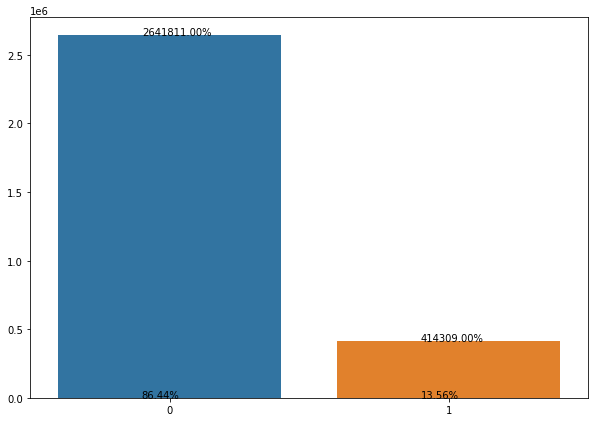

In [32]:
plt.figure(figsize=(8, 6))

# plot_feature_freq(df, feature, qt_cat)
plot_feature_freq(X_ta, 'trocou_aparelho')

Base Prevista

In [33]:
X_ta['trocou_aparelho_previsto'] = preds_ta
# X_ta

<Figure size 576x432 with 0 Axes>

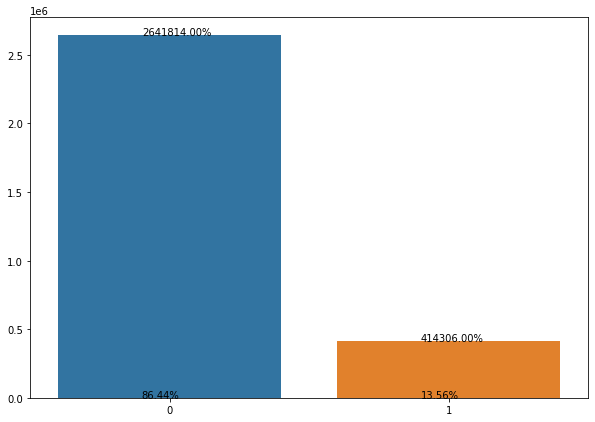

In [34]:
plt.figure(figsize=(8, 6))

plot_feature_freq(X_ta, 'trocou_aparelho_previsto')

In [35]:
X_ta['cpfidentifier'] = dados_droped['cpfidentifier']
# X_ta

In [36]:
X_ta['dt_inicio'] = dados_droped['dt_inicio']
# X_ta

In [37]:
X_ta['dt_fim'] = dados_droped['dt_fim']
X_ta['modelo'] = dados_droped['modelo']
X_ta['subscribermainofferdesc'] = dados_droped['subscribermainofferdesc']
X_ta['assignedchargeamount'] = dados_droped['assignedchargeamount']
X_ta['offertechnology'] = dados_droped['offertechnology']
X_ta['statedesc'] = dados_droped['statedesc']
X_ta['fl_3g'] = dados_droped['fl_3g']
X_ta['fl_4g'] = dados_droped['fl_4g']
# X_ta['fl_5g'] = dados_droped['fl_5g']
X_ta['idade'] = dados_droped['idade']
X_ta['avg_msisdn'] = dados_droped['avg_msisdn']
X_ta['avg_cpf'] = dados_droped['avg_cpf']

X_ta

,msisdn,imsi,tac,dt_inicio,dt_fim,aging_aparelho,cat_aparelho,fabricante,modelo,imei,...,fl_3g,fl_4g,dt_ano_stts,idade,avg_msisdn,avg_cpf,peso_aparelho,update_software,trocou_aparelho,trocou_aparelho_previsto
0,5551999820515,724065202978919,35682055,2021-08-20,NaN,16,1,APPLE,IPHONE 12 PRO MAX (A2411),356820555315760,...,0,0,2021,90,0.0,0.0,2411,1,0,0
1,5551999992102,724065303215186,35391510,2019-10-19,NaN,38,3,APPLE,IPHONE 11 PRO MAX (A2218),353915101542490,...,0,1,2019,90,0.0,0.0,2218,1,0,0
2,5551999824802,724065202953487,35729809,2019-10-22,NaN,38,3,APPLE,IPHONE XS MAX (A2101),357298097342520,...,0,1,2018,90,0.0,0.0,2101,1,0,0
3,5551995954042,724065202953488,35003844,2021-12-17,NaN,12,1,APPLE,IPHONE 13 (A2633),350038449113620,...,0,0,2021,90,0.0,0.0,2633,1,0,0
4,5566999794019,724066612780171,35298611,2020-10-23,NaN,26,2,APPLE,IPHONE 11 (A2221),352986117774170,...,0,1,2020,48,0.0,0.0,2221,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3056115,5527997767218,724113090182121,35533608,2019-06-14,NaN,42,3,APPLE,IPHONE 7 (A1779),355336080783810,...,0,1,2016,54,0.0,0.0,1779,0,0,0
3056116,5527996100063,724112703043033,35491409,2020-07-16,2022-08-04,24,2,APPLE,IPHONE 7 (A1660),354914095756020,...,0,1,2018,56,24.0,24.0,1660,0,1,1
3056117,5551997094150,724065190358565,35728409,2019-01-10,NaN,48,4,APPLE,IPHONE XS MAX (A2101),357284091422250,...,0,1,2018,41,0.0,0.0,2101,1,0,0
3056118,5551981916776,724065006634070,35391410,2020-04-28,NaN,32,2,APPLE,IPHONE 11 PRO MAX (A2218),353914106530060,...,0,1,2019,41,0.0,0.0,2218,1,0,0


In [38]:
val_acc_ta = accuracy_score(y_ta, preds_ta)
print('Validation Acuracy:', val_acc_ta)

Validation Acuracy: 0.9999990183631533


***
***
***
## Separando as bases para outro modelo

In [39]:
base_to_pred_month = X_ta[X_ta['trocou_aparelho_previsto'] == 1].reset_index(drop=True)
base_to_pred_month

,msisdn,imsi,tac,dt_inicio,dt_fim,aging_aparelho,cat_aparelho,fabricante,modelo,imei,...,fl_3g,fl_4g,dt_ano_stts,idade,avg_msisdn,avg_cpf,peso_aparelho,update_software,trocou_aparelho,trocou_aparelho_previsto
0,5551995977894,724065005997730,35291811,2020-08-07,2022-09-12,25,2,APPLE,IPHONE 11 (A2221),352918118384710,...,0,1,2020,43,25.0,25.0,2221,1,1,1
1,5521999048600,724112005300513,35735809,2019-01-13,2022-10-09,44,3,APPLE,IPHONE XR (A2105),357358094960130,...,0,1,2018,54,44.0,12.0,2105,1,1,1
2,5537999859602,724233608728525,35926706,2020-01-29,2022-10-21,32,2,APPLE,IPHONE 5S (A1457),359267069591040,...,0,1,2015,58,32.0,32.0,1457,0,1,1
3,5551998169677,724065007435855,35307409,2018-12-12,2022-07-15,43,3,APPLE,IPHONE 7 (A1778),353074094773080,...,0,1,2018,40,22.5,22.5,1778,0,1,1
4,5554999161144,724065303571480,35676308,2019-06-12,2022-10-05,39,3,APPLE,IPHONE 8 (A1905),356763086784710,...,0,1,2017,55,39.0,39.0,1905,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414301,5511971419892,724101002363049,35330207,2018-10-14,2022-09-12,46,3,APPLE,IPHONE 6S PLUS TD-LTE (A1634),353302070914660,...,0,1,2015,68,46.0,46.0,1634,0,1,1
414302,5531971280177,724234290903081,35645210,2020-10-10,2022-07-24,21,1,APPLE,IPHONE XR (A2105),356452109534520,...,0,1,2019,59,21.0,21.0,2105,1,1,1
414303,5511981118011,724101703573155,35298911,2020-08-27,2022-08-12,23,1,APPLE,IPHONE 11 (A2221),352989114721080,...,0,1,2020,70,23.0,23.0,2221,1,1,1
414304,5527996100063,724112703043033,35491409,2020-07-16,2022-08-04,24,2,APPLE,IPHONE 7 (A1660),354914095756020,...,0,1,2018,56,24.0,24.0,1660,0,1,1


***
***
***
## Definição do Target aging_aparelho

In [40]:
# define target
y = base_to_pred_month['aging_aparelho']

In [41]:
# contagem de aging
from collections import Counter

c = Counter(y)
c

Counter({25: 11819,
         44: 5585,
         32: 11522,
         43: 5958,
         39: 6111,
         14: 20158,
         20: 16525,
         16: 17369,
         13: 20839,
         18: 16225,
         23: 14344,
         17: 16961,
         19: 16019,
         21: 16577,
         33: 11268,
         45: 5224,
         42: 5677,
         31: 10613,
         29: 9244,
         27: 9440,
         38: 6354,
         22: 15558,
         35: 9836,
         24: 12366,
         28: 8966,
         12: 23936,
         37: 6983,
         15: 18777,
         30: 9524,
         36: 8418,
         34: 10511,
         46: 4821,
         26: 11126,
         41: 5879,
         48: 3421,
         40: 6059,
         47: 4293})

<Figure size 1440x432 with 0 Axes>

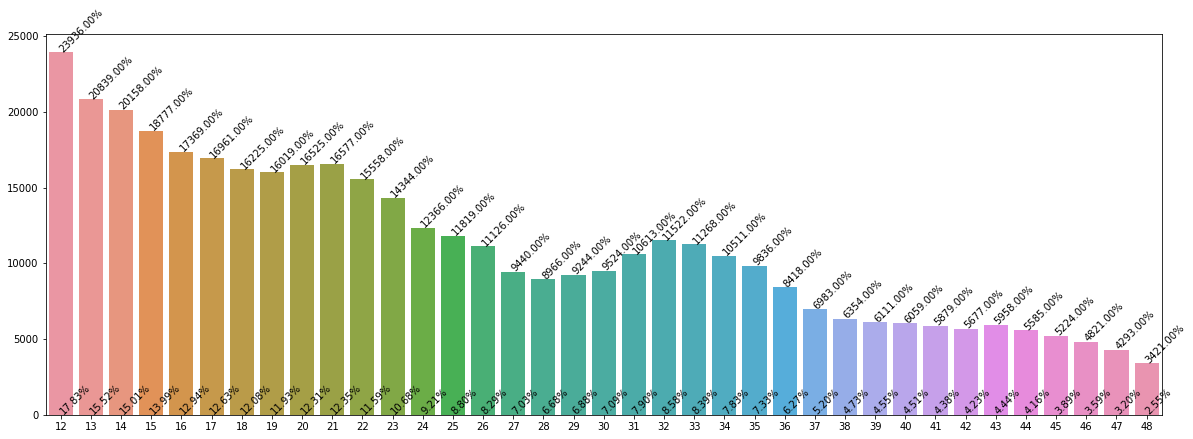

In [42]:
plt.figure(figsize=(20, 6))

# plot_feature_freq(df, feature, qt_cat)
plot_feature_freq_mes(base_to_pred_month, 'aging_aparelho')

***
### Load Model

In [43]:
# Open saved model, and directly make the prediction with new data
filename_ag = '/kaggle/input/models/model_aging_apple.pk'
with open(filename_ag ,'rb') as f:
    pipeline = pickle.load(f)

In [44]:
X = base_to_pred_month.drop('aging_aparelho', axis=1)

y = base_to_pred_month['aging_aparelho']

In [45]:
preds = pipeline.predict(X)

In [46]:
c_val = Counter(y)
c_val

Counter({25: 11819,
         44: 5585,
         32: 11522,
         43: 5958,
         39: 6111,
         14: 20158,
         20: 16525,
         16: 17369,
         13: 20839,
         18: 16225,
         23: 14344,
         17: 16961,
         19: 16019,
         21: 16577,
         33: 11268,
         45: 5224,
         42: 5677,
         31: 10613,
         29: 9244,
         27: 9440,
         38: 6354,
         22: 15558,
         35: 9836,
         24: 12366,
         28: 8966,
         12: 23936,
         37: 6983,
         15: 18777,
         30: 9524,
         36: 8418,
         34: 10511,
         46: 4821,
         26: 11126,
         41: 5879,
         48: 3421,
         40: 6059,
         47: 4293})

In [47]:
c_preds = Counter(preds)
c_preds

Counter({25: 11517,
         44: 5154,
         32: 10275,
         45: 4991,
         39: 5993,
         14: 21409,
         20: 17488,
         16: 19277,
         13: 21948,
         18: 17031,
         23: 14515,
         17: 18347,
         19: 16406,
         21: 16631,
         42: 5195,
         31: 10596,
         29: 9117,
         27: 9384,
         38: 5850,
         22: 16510,
         35: 9596,
         24: 11259,
         12: 26065,
         37: 6841,
         15: 20064,
         36: 7623,
         33: 10753,
         34: 9384,
         43: 5767,
         46: 4475,
         26: 9860,
         30: 8342,
         41: 5786,
         48: 3166,
         28: 7995,
         40: 5466,
         47: 4230})

***
## Métricas

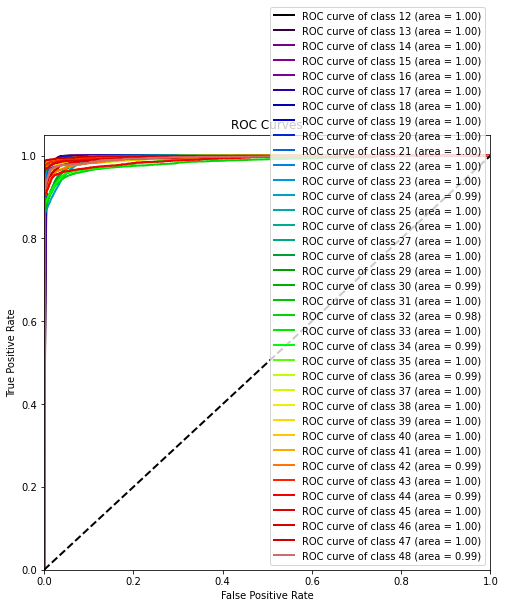

In [48]:
y_probas = pipeline.predict_proba(X)
plot_roc(y, y_probas, plot_micro = False, plot_macro = False, figsize = (8, 8))
plt.show()

In [49]:
print(classification_report(y, preds))

              precision    recall  f1-score   support

          12       0.88      0.95      0.91     23936
          13       0.88      0.92      0.90     20839
          14       0.87      0.93      0.90     20158
          15       0.88      0.94      0.90     18777
          16       0.85      0.94      0.89     17369
          17       0.87      0.94      0.90     16961
          18       0.88      0.93      0.90     16225
          19       0.91      0.93      0.92     16019
          20       0.89      0.95      0.92     16525
          21       0.92      0.93      0.92     16577
          22       0.90      0.96      0.93     15558
          23       0.94      0.95      0.94     14344
          24       0.94      0.86      0.90     12366
          25       0.96      0.94      0.95     11819
          26       0.98      0.87      0.93     11126
          27       0.96      0.95      0.95      9440
          28       0.98      0.87      0.92      8966
          29       0.97    

In [50]:
cm_df = pd.DataFrame(confusion_matrix(y, preds),
                     index = sorted(Counter(y)),
                     columns = sorted(Counter(preds)))
cm_df

,12,13,14,15,16,17,18,19,20,21,...,39,40,41,42,43,44,45,46,47,48
12,22812,572,303,162,23,8,18,4,1,0,...,0,0,0,0,0,0,0,0,0,0
13,633,19249,473,281,141,17,1,2,3,0,...,0,0,0,0,0,0,0,0,0,0
14,210,367,18681,473,249,117,12,7,3,7,...,0,0,0,0,0,0,0,0,0,0
15,123,142,188,17569,402,237,66,16,1,1,...,0,0,0,0,0,0,0,0,0,0
16,132,48,55,148,16345,342,155,80,9,0,...,0,0,0,0,0,0,1,0,0,0
17,121,14,48,102,176,15963,246,180,70,9,...,0,0,0,0,0,0,0,0,0,0
18,259,25,61,22,82,184,15033,267,186,57,...,0,0,0,0,0,0,0,0,0,0
19,36,15,75,24,72,76,281,14912,307,111,...,0,0,0,0,0,0,0,0,0,0
20,35,20,95,31,20,12,89,124,15636,178,...,1,17,0,0,0,0,0,0,0,0
21,77,22,208,10,13,2,28,109,338,15341,...,0,1,6,34,0,0,0,0,0,0


## Plot non-normalized confusion matrix

In [51]:
y.unique()

array([25, 44, 32, 43, 39, 14, 20, 16, 13, 18, 23, 17, 19, 21, 33, 45, 42,
       31, 29, 27, 38, 22, 35, 24, 28, 12, 37, 15, 30, 36, 34, 46, 26, 41,
       48, 40, 47])

Confusion matrix, without normalization
[[22812   572   303 ...     0     0     0]
 [  633 19249   473 ...     0     0     0]
 [  210   367 18681 ...     0     0     0]
 ...
 [    2     0     0 ...  4408    34     4]
 [    1     0     0 ...    43  4157    11]
 [    1     0     0 ...     0     7  3123]]
Normalized confusion matrix
[[9.53041444e-01 2.38970588e-02 1.26587567e-02 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.03757378e-02 9.23700753e-01 2.26978262e-02 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.04177002e-02 1.82061712e-02 9.26728842e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [4.14851691e-04 0.00000000e+00 0.00000000e+00 ... 9.14333126e-01
  7.05247874e-03 8.29703381e-04]
 [2.32937340e-04 0.00000000e+00 0.00000000e+00 ... 1.00163056e-02
  9.68320522e-01 2.56231074e-03]
 [2.92312189e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  2.04618533e-03 9.12890968e-01]]


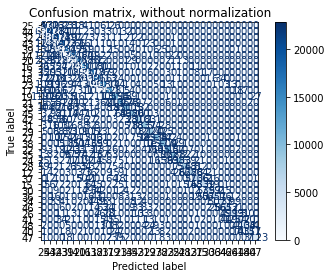

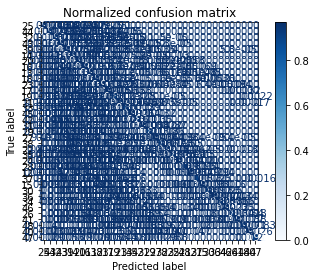

<Figure size 1800x1800 with 0 Axes>

In [52]:
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        pipeline,
        X,
        y,
        display_labels=y.unique(),
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)
    
plt.figure(figsize=(25, 25))
plt.show()

***
## Mesclando resultados com tabela

### Com a base de validação

In [53]:
X['aging_aparelho'] = y
# X

In [54]:
X['aging_aparelho_previsto'] = preds
# X

In [55]:
X['cpfidentifier'] = base_to_pred_month['cpfidentifier']
# X

In [56]:
X['dt_inicio'] = base_to_pred_month['dt_inicio']
# X

In [57]:
X['dt_fim'] = base_to_pred_month['dt_fim']
# X

In [58]:
val_acc = accuracy_score(y, preds)
print('Validation Acuracy:', val_acc)

Validation Acuracy: 0.9261536159263926


<Figure size 1440x432 with 0 Axes>

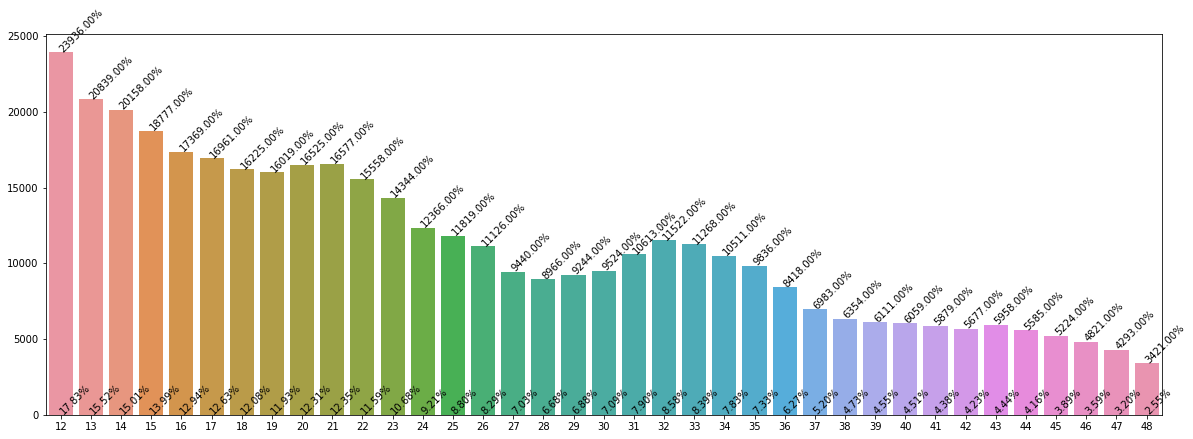

In [59]:
plt.figure(figsize=(20, 6))

# plot_feature_freq(df, feature, qt_cat)
plot_feature_freq_mes(X, 'aging_aparelho')

<Figure size 1440x432 with 0 Axes>

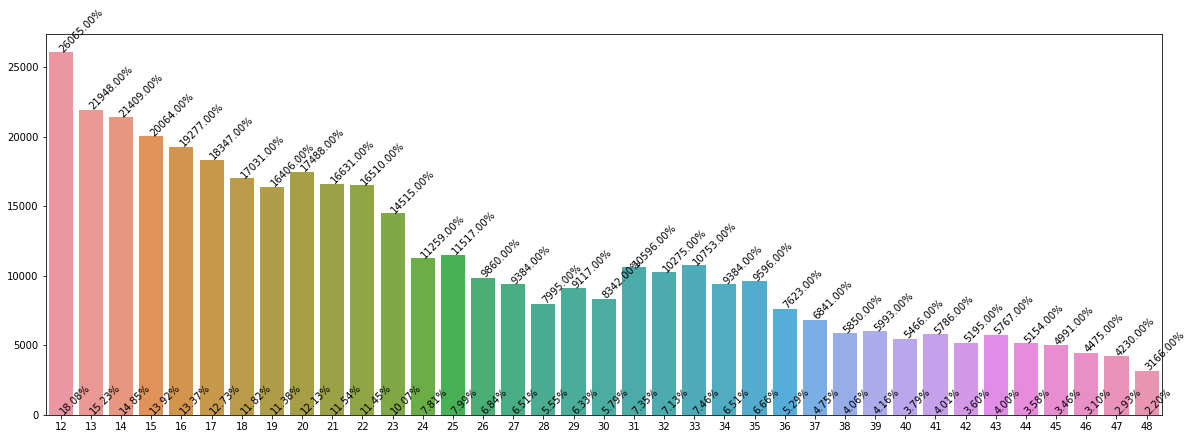

In [60]:
plt.figure(figsize=(20, 6))

# plot_feature_freq(df, feature, qt_cat)
plot_feature_freq_mes(X, 'aging_aparelho_previsto')

***
## Calculando data prevista

In [61]:
X['dt_fim_previsto'] = ((pd.to_datetime(X['dt_inicio']).dt.to_period('M')) + X['aging_aparelho_previsto'])
X

,msisdn,imsi,tac,dt_inicio,dt_fim,cat_aparelho,fabricante,modelo,imei,ranking,...,idade,avg_msisdn,avg_cpf,peso_aparelho,update_software,trocou_aparelho,trocou_aparelho_previsto,aging_aparelho,aging_aparelho_previsto,dt_fim_previsto
0,5551995977894,724065005997730,35291811,2020-08-07,2022-09-12,2,APPLE,IPHONE 11 (A2221),352918118384710,1,...,43,25.0,25.0,2221,1,1,1,25,25,2022-09
1,5521999048600,724112005300513,35735809,2019-01-13,2022-10-09,3,APPLE,IPHONE XR (A2105),357358094960130,1,...,54,44.0,12.0,2105,1,1,1,44,44,2022-09
2,5537999859602,724233608728525,35926706,2020-01-29,2022-10-21,2,APPLE,IPHONE 5S (A1457),359267069591040,1,...,58,32.0,32.0,1457,0,1,1,32,32,2022-09
3,5551998169677,724065007435855,35307409,2018-12-12,2022-07-15,3,APPLE,IPHONE 7 (A1778),353074094773080,1,...,40,22.5,22.5,1778,0,1,1,43,45,2022-09
4,5554999161144,724065303571480,35676308,2019-06-12,2022-10-05,3,APPLE,IPHONE 8 (A1905),356763086784710,1,...,55,39.0,39.0,1905,1,1,1,39,39,2022-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414301,5511971419892,724101002363049,35330207,2018-10-14,2022-09-12,3,APPLE,IPHONE 6S PLUS TD-LTE (A1634),353302070914660,1,...,68,46.0,46.0,1634,0,1,1,46,46,2022-08
414302,5531971280177,724234290903081,35645210,2020-10-10,2022-07-24,1,APPLE,IPHONE XR (A2105),356452109534520,1,...,59,21.0,21.0,2105,1,1,1,21,21,2022-07
414303,5511981118011,724101703573155,35298911,2020-08-27,2022-08-12,1,APPLE,IPHONE 11 (A2221),352989114721080,1,...,70,23.0,23.0,2221,1,1,1,23,23,2022-07
414304,5527996100063,724112703043033,35491409,2020-07-16,2022-08-04,2,APPLE,IPHONE 7 (A1660),354914095756020,1,...,56,24.0,24.0,1660,0,1,1,24,24,2022-07


In [62]:
X.to_excel(r'ta_predicted_apple.xlsx')

In [63]:
X.to_csv(r'ta_predicted_apple.csv')